In [1]:
import pandas as pd
from pathlib import Path
import os
import random
import numpy as np
import json
from datetime import timedelta
from collections import Counter
from tqdm.notebook import tqdm
from heapq import nlargest

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
### Paths ###

DATA_PATH = Path('/content/drive/MyDrive/KAGGLE/Shopper-2022/otto-recommender-system')
TRAIN_PATH = DATA_PATH/'train.jsonl'
TEST_PATH = DATA_PATH/'test.jsonl'
SAMPLE_SUB_PATH = Path('/content/drive/MyDrive/KAGGLE/Shopper-2022/otto-recommender-system/sample_submission.csv')

In [3]:
# Lets check how many lines the training data has!

with open(TRAIN_PATH, 'r') as f:
    print(f"We have {len(f.readlines()):,} lines in the training data")

We have 12,899,779 lines in the training data


In [4]:
# Load in a sample to a pandas df

sample_size = 150000

chunks = pd.read_json(TRAIN_PATH, lines=True, chunksize = sample_size)

for c in chunks:
    sample_train_df = c
    break

In [5]:
sample_train_df.set_index('session', drop=True, inplace=True)
sample_train_df.head()

,events
session,
0,"[{'aid': 1517085, 'ts': 1659304800025, 'type':..."
1,"[{'aid': 424964, 'ts': 1659304800025, 'type': ..."
2,"[{'aid': 763743, 'ts': 1659304800038, 'type': ..."
3,"[{'aid': 1425967, 'ts': 1659304800095, 'type':..."
4,"[{'aid': 613619, 'ts': 1659304800119, 'type': ..."


### Data structure
session - 고유한 세션 ID입니다. 각 세션에는 시간순으로 정렬된 이벤트 목록이 포함됩니다.

events - 세션에서 이벤트의 시간 순서 시퀀스입니다. 각 이벤트에는 3가지 정보가 포함됩니다.

1. aid - 관련 이벤트의 아티클 ID(제품 코드)

2. ts - 이벤트의 유닉스 타임스탬프(유닉스 타임스탬프는 1970년 1월 1일 00:00:00 UTC 이후 경과된 마이크로초 수입니다.)

3. type - 이벤트 유형, 즉 제품을 클릭했는지(클릭했는지), 사용자 카트에 추가했는지(클릭했는지), 세션 중에 주문했는지(주문)

In [6]:
# Let's look at an example session and print out some basic info

# Sample the first session in the df
example_session = sample_train_df.iloc[0].item()
print(f'This session was {len(example_session)} actions long \n')
print(f'The first action in the session: \n {example_session[0]} \n')

# Time of session
time_elapsed = example_session[-1]["ts"] - example_session[0]["ts"]
# The timestamp is in microseconds since 00:00:00 UTC on 1 January 1970
print(f'The first session elapsed: {str(timedelta(microseconds=time_elapsed))} \n')

# Count the frequency of actions within the session
action_counts = {}
for action in example_session:
    action_counts[action['type']] = action_counts.get(action['type'], 0) + 1  
print(f'The first session contains the following frequency of actions: {action_counts}')

This session was 276 actions long 

The first action in the session: 
 {'aid': 1517085, 'ts': 1659304800025, 'type': 'clicks'} 

The first session elapsed: 0:39:40.183682 

The first session contains the following frequency of actions: {'clicks': 255, 'carts': 17, 'orders': 4}


### EDA

In [7]:
### Extract information from each session and add it to the df ###

action_counts_list, article_id_counts_list, session_length_time_list, session_length_action_list = ([] for i in range(4))
overall_action_counts = {}
overall_article_id_counts = {}

for i, row in tqdm(sample_train_df.iterrows(), total=len(sample_train_df)):
    
    actions = row['events']
    
    # Get the frequency of actions and article_ids
    action_counts = {}
    article_id_counts = {}
    for action in actions:
        action_counts[action['type']] = action_counts.get(action['type'], 0) + 1
        article_id_counts[action['aid']] = article_id_counts.get(action['aid'], 0) + 1
        overall_action_counts[action['type']] = overall_action_counts.get(action['type'], 0) + 1
        overall_article_id_counts[action['aid']] = overall_article_id_counts.get(action['aid'], 0) + 1
        
    # Get the length of the session
    session_length_time = actions[-1]['ts'] - actions[0]['ts']
    
    # Add to list
    action_counts_list.append(action_counts)
    article_id_counts_list.append(article_id_counts)
    session_length_time_list.append(session_length_time)
    session_length_action_list.append(len(actions))
    
sample_train_df['action_counts'] = action_counts_list
sample_train_df['article_id_counts'] = article_id_counts_list
sample_train_df['session_length_unix'] = session_length_time_list
sample_train_df['session_length_minutes'] = sample_train_df['session_length_unix']*1.66667e-8    # Convert to minutes
sample_train_df['session_length_action'] = session_length_action_list

  0%|          | 0/150000 [00:00<?, ?it/s]

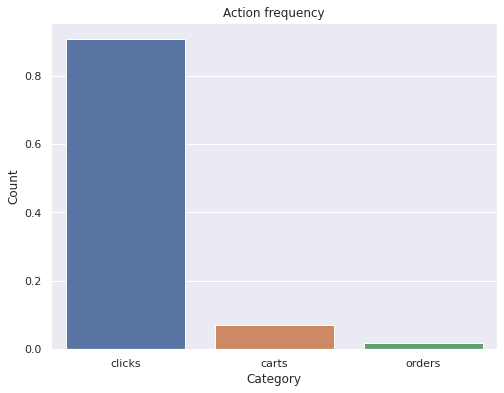

In [8]:
### Actions ###

total_actions = sum(overall_action_counts.values())

plt.figure(figsize=(8,6))
sns.barplot(x=list(overall_action_counts.keys()), y=[i/total_actions for i in overall_action_counts.values()]);
plt.title(f'Action frequency', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

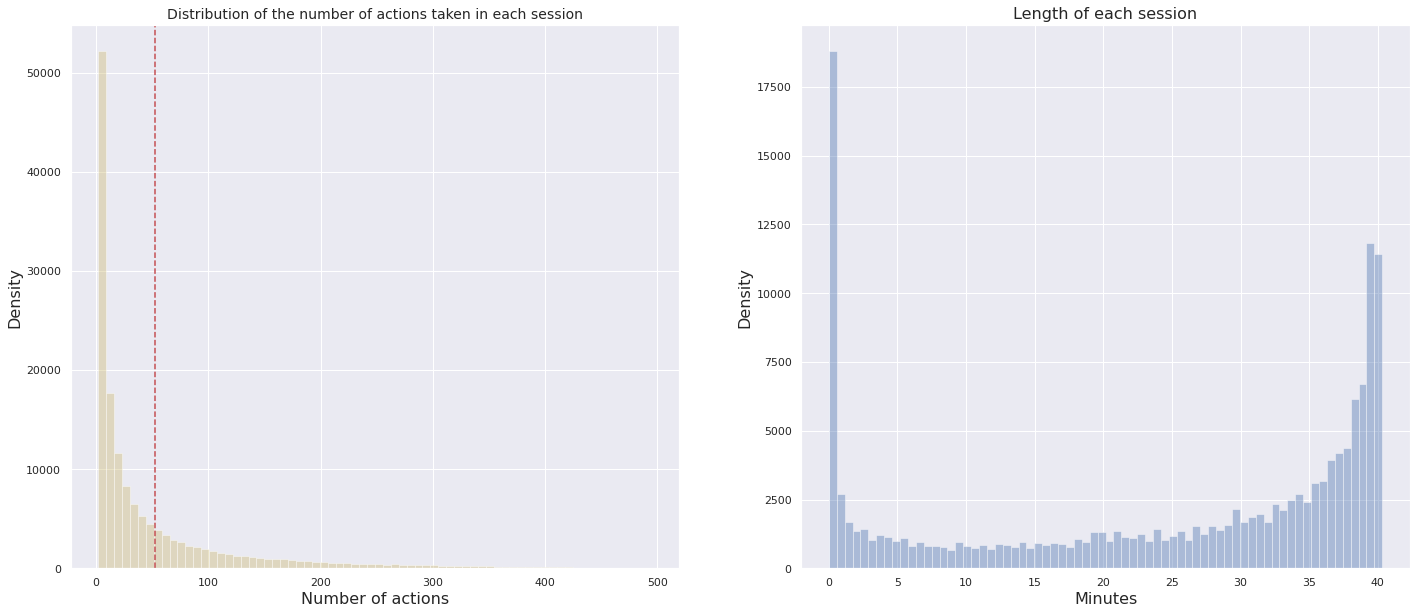

In [9]:
fig, ax = plt.subplots(1,2, figsize=(24, 10))

p = sns.distplot(sample_train_df['session_length_action'], color="y", bins= 70, ax=ax[0], kde=False)
p.set_xlabel("Number of actions", fontsize = 16)
p.set_ylabel("Density", fontsize = 16)
p.set_title("Distribution of the number of actions taken in each session", fontsize = 14)
p.axvline(sample_train_df['session_length_action'].mean(), color='r', linestyle='--', label="Mean")

p = sns.distplot(sample_train_df['session_length_minutes'], color="b", bins= 70, ax=ax[1], kde=False)
p.set_xlabel("Minutes", fontsize = 16)
p.set_ylabel("Density", fontsize = 16)
p.set_title("Length of each session", fontsize = 16);

In [10]:
print(f'{round(len(sample_train_df[sample_train_df["session_length_action"]<10])/len(sample_train_df),3)*100}% of the sessions had less than 10 actions')

34.8% of the sessions had less than 10 actions


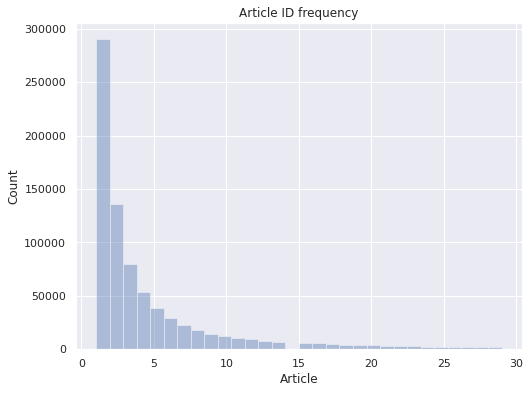

In [11]:
article_id_freq = list(overall_article_id_counts.values())
cut_off = [i for i in article_id_freq if i<30]

plt.figure(figsize=(8,6))
sns.distplot(cut_off, bins=30, kde=False);
plt.title(f'Article ID frequency', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Article', fontsize=12);

In [12]:
### Look at the most interacted with articles ###
print(f'Frequency of most common articles: {sorted(list(overall_article_id_counts.values()))[-5:]} \n')
res = nlargest(5, overall_article_id_counts, key = overall_article_id_counts.get)
print(f'IDs for those common articles: {res}')

Frequency of most common articles: [3877, 4259, 4323, 4503, 5000] 

IDs for those common articles: [29735, 1603001, 832192, 1733943, 108125]


### Baseline Code

'테스트 데이터'에는 훈련 데이터와 유사한 잘린 세션 데이터가 포함되어 있다. 이 작업은 세션 잘라내기 후 클릭되는 다음 보조 도구와 카트 및 주문에 추가되는 나머지 보조 도구를 예측하는 것입니다. 각 세션 유형에 대해 최대 20개의 값을 예측할 수 있습니다.

제출된 내용은 각 작업 유형별 리콜에서 평가되며, 세 가지 리콜 값은 가중치 평균이 적용됩니다. {'클릭': 0.10, '카트': 0.30, '주문': 0.60}. 대부분의 가중치가 적용되므로 '주문' 예측을 정확하게 하는 것이 중요합니다. :)

테스트 데이터의 각 세션에 대해 마지막 타임스탬프가 테스트 세션을 수행한 후 발생하는 각 유형에 대한 보조 값을 예측하는 작업을 수행합니다. 즉, 테스트 데이터에는 타임스탬프에 의해 잘린 세션이 포함되어 있으며 잘린 지점 이후에 어떤 일이 발생할지 예측해야 합니다.

클릭의 경우 각 세션에 대한 실제 값은 하나뿐이며, 이 값은 세션 중에 클릭된 다음 보조 값입니다(최대 20개의 보조 값을 예측할 수 있음). 카트 및 주문에 대한 기본 진실에는 세션 중에 각각 카트에 추가되고 주문된 모든 지원 값이 포함됩니다.

각 세션 및 유형 조합은 제출의 session_type 행(세션당 3개 행)에 나타나야 하며 예측은 공백으로 구분되어야 합니다. 이는 아래의 sample_test_df에서 확인할 수 있습니다.

In [13]:
with open(TEST_PATH, 'r') as f:
    print(f"We have {len(f.readlines()):,} lines in the test data")

We have 1,671,803 lines in the test data


In [14]:
# Load in a sample to a pandas df

sample_size = 150

chunks = pd.read_json(TEST_PATH, lines=True, chunksize = sample_size)

for c in chunks:
    sample_test_df = c
    break

In [15]:
sample_test_df.head()

,session,events
0,12899779,"[{'aid': 59625, 'ts': 1661724000278, 'type': '..."
1,12899780,"[{'aid': 1142000, 'ts': 1661724000378, 'type':..."
2,12899781,"[{'aid': 141736, 'ts': 1661724000559, 'type': ..."
3,12899782,"[{'aid': 1669402, 'ts': 1661724000568, 'type':..."
4,12899783,"[{'aid': 255297, 'ts': 1661724000572, 'type': ..."


검정 집합의 각 세션에 대해 예측(라벨)이 있습니다. 이것은 해당 세션에서 다음에 상호 작용할 기사를 예측합니다. 각 세션에는 세 가지 동작(클릭, 카트, 주문)이 있으며 세 가지 동작 모두에 대한 예측이 이루어집니다.

In [16]:
sample_submission = pd.read_csv(SAMPLE_SUB_PATH)
sample_submission.head()

,session_type,labels
0,12899779_clicks,129004 126836 118524
1,12899779_carts,129004 126836 118524
2,12899779_orders,129004 126836 118524
3,12899780_clicks,129004 126836 118524
4,12899780_carts,129004 126836 118524


In [17]:
sample_size = 150000

chunks = pd.read_json(TRAIN_PATH, lines=True, chunksize = sample_size)

clicks_article_list = []
carts_article_list = []
orders_article_list = []

for e, c in enumerate(chunks):
    
    # Save time by not using all the data
    if e > 2:
        break
    
    sample_train_df = c
    
    for i, row in c.iterrows():
        actions = row['events']
        for action in actions:
            if action['type'] == 'clicks':
                clicks_article_list.append(action['aid'])
            elif action['type'] == 'carts':
                carts_article_list.append(action['aid'])
            else:
                orders_article_list.append(action['aid'])

In [18]:
# Create dictionaries with articles and their frequencies
article_click_freq = Counter(clicks_article_list)
article_carts_freq = Counter(carts_article_list)
article_order_freq = Counter(orders_article_list)

In [19]:
# Get the 20 most frequent articles for each action
top_click_article = nlargest(20, article_click_freq, key = article_click_freq.get)
top_carts_article = nlargest(20, article_carts_freq, key = article_carts_freq.get)
top_order_article = nlargest(20, article_order_freq, key = article_order_freq.get) 

In [20]:
# Create a dict with this info
frequent_articles = {'clicks': top_click_article, 'carts':top_carts_article, 'order':top_order_article}

In [21]:
for action in ['clicks', 'carts', 'order']:
    print(f'Most frequent articles for {action}: {frequent_articles[action][-5:]}')

Most frequent articles for clicks: [1196256, 1502122, 673407, 508883, 1743151]
Most frequent articles for carts: [1743151, 544144, 1498443, 351335, 247240]
Most frequent articles for order: [923948, 801774, 247240, 1111967, 563117]


중복되는 부분이 있지만 기사는 다른 작업에 따라 변경됩니다!

이 기준선은 사람들이 이전에 상호 작용했던 기사와 자주 상호 작용한다는 사실을 사용할 것이다. 예측은 세션에서 가장 자주 사용되는 상위 20개 기사로 구성됩니다. 세션에 20개 미만의 기사가 있는 경우 위에서 확인한 것처럼 교육 데이터에서 가장 자주 나오는 기사로 예측이 패딩됩니다.

In [22]:
test_data = pd.read_json(TEST_PATH, lines=True, chunksize=1000)

preds = []

for chunk in tqdm(test_data, total=1671):
    
    for i, row in chunk.iterrows():
        actions = row['events']
        article_id_list = []
        for action in actions:
            article_id_list.append(action['aid'])
            
        # Get 20 most common article ID for the session
        article_freq = Counter(article_id_list)
        top_articles = nlargest(20, article_freq, key = article_freq.get)
        
        # Pad with most popular items in training
        padding_size = -(20 - len(top_articles))
        for action in ['clicks', 'carts', 'order']:
            top_articles = top_articles + frequent_articles[action][padding_size:]
            preds.append(" ".join([str(id) for id in top_articles]))

  0%|          | 0/1671 [00:00<?, ?it/s]

In [23]:
import math
# Predict the 20 most common atricles for each test session
sample_submission['labels'] = preds

In [24]:
sample_submission.to_csv('/content/drive/MyDrive/KAGGLE/Shopper-2022/otto-recommender-system/submission.csv', index=False)